# MAML - MODEL-AGNOSTIC META-LEARNING

In [ ]:
!pip install import_ipynb --quiet

In [ ]:
!pip install learn2learn --quiet

     |████████████████████████████████| 841 kB 7.6 MB/s 
     |████████████████████████████████| 2.9 MB 43.5 MB/s 
     |████████████████████████████████| 135 kB 66.7 MB/s 
     |████████████████████████████████| 96 kB 5.8 MB/s 
     |████████████████████████████████| 55 kB 4.0 MB/s 
     |████████████████████████████████| 1.4 MB 51.4 MB/s 
     |████████████████████████████████| 3.6 MB 38.5 MB/s 


In [ ]:
import requests
import pickle

In [ ]:
#If on colab:
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/utils.ipynb?raw=true")
with open('./utils.ipynb','wb') as f: f.write(r.content)
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/course_data.ipynb?raw=true")
with open('./course_data.ipynb','wb') as f: f.write(r.content)


In [ ]:
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/code/l2lutils.ipynb?raw=true")
with open('./l2lutils.ipynb','wb') as f: f.write(r.content)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:

%ls drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'

CNP.ipynb          l2lutils.ipynb  models.ipynb  nb3-CNP.ipynb  utils.ipynb
course_data.ipynb  MAN.ipynb       nb2.ipynb     nb3-MAN.ipynb


In [ ]:
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/models.ipynb .
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/utils.ipynb .
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/course_data.ipynb .
!cp drive/MyDrive/'Colab Notebooks'/'Meta_Learning_hw2'/l2lutils.ipynb .


In [ ]:
import import_ipynb
import utils
import models
utils.hide_toggle('Imports 1')

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from models.ipynb


In [ ]:

from IPython import display
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display
utils.hide_toggle('Imports 2')

importing Jupyter notebook from l2lutils.ipynb


In [ ]:
#If on colab
from course_data import MyDS, ImageData, TsDS, FeedData

importing Jupyter notebook from course_data.ipynb


# Get Data

In [ ]:
#If on Colab/student machine use the next few lines to load image data:
r=requests.get("https://github.com/gmshroff/metaLearning2022/blob/main/data/image_data.pickle.zip?raw=true")

In [ ]:
with open('./image_data.pickle.zip','wb') as f: f.write(r.content)
!unzip ./image_data.pickle.zip

In [ ]:
with open('./image_data.pickle','rb') as f: imageData=pickle.load(f)

# Pre-trained Models

In [ ]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=10000,n_features=20,n_classes=10,batch_size=32)

In [ ]:
meta_train_ds,meta_test_ds,mapping,full_loader=imageData.train_ds,imageData.test_ds,imageData.mapping,imageData.dloader

In [ ]:
# Define an MLP network. Note that input dimension has to be data dimension. For classification
# final dimension has to be number of classes; for regression one.
#torch.manual_seed(10)
#net0 = models.MLP(dims=[20,32,32,10])
net0 = models.MLP(dims=[400,64,32,len(mapping.keys())])

In [ ]:
# Train the network; note that network is trained in place so repeated calls further train it.
net0,loss,accs=models.Train(net0,full_loader,lr=1e-3,epochs=10,verbose=True)

In [ ]:
#Training accuracy.
models.accuracy(net0,meta_train_ds.samples,meta_train_ds.labels,verbose=True)

In [ ]:
# Test accuracy.
models.accuracy(net0,meta_test_ds.samples,meta_test_ds.labels)

In [ ]:
len(mapping.keys())

# Second-order Differentiation using Autograd

Second-order derivatives as needed for MAML

In [ ]:
network = (lambda x,w: x@w)
loss = torch.nn.MSELoss()

In [ ]:
Z=(torch.ones(3,1)).float()
z=(torch.ones(3,1)*2).float()

In [ ]:
Zt=(torch.ones(3,1)*1.5).float()
zt=(torch.ones(3,1)*2*1.5).float()

In [ ]:
w0=(torch.ones(1,1,requires_grad=True)).float()

In [ ]:
w1=w0.clone()

In [ ]:
L=loss(network(Z,w1),z)

In [ ]:
#g=torch.autograd.grad(L,w0)[0]
g=torch.autograd.grad(L,w1,create_graph=True)[0]
#L.backward(create_graph=True)# Not good

In [ ]:
w1.grad, w0.grad, L, w0, w1,w1.requires_grad,g

In [ ]:
w1 = w1 - 0.1*g

In [ ]:
L1=loss(network(Zt,w1),zt)
#L1=loss(net(Zt,w0-0.1*(2.0*(w0-2.0))),zt)

In [ ]:
# Both OK - latter used with optimizer.step()
g1=torch.autograd.grad(L1,w0)[0]
#L1.backward()

In [ ]:
g1

Working this out manually:

$w_0=1, L=(w_0-2)^2, dL=2\times(w_0-2)=-2,w_1=w_0-0.1\times(-2)=1.2$

$L_1=(w_1\times1.5-3)^2 = (w_0-0.1\times(2\times(w_0-2))\times1.5-3)^2 = (-1.2)^2$

$dL_1 = 2 \times (-1.2) \times (1.5 \times (1-.2))$

In [ ]:
2*(-1.2)*(1.5*(1-.2))

In [ ]:
w0.grad,w1.grad

# Meta-Learning: Tasks

Generate a k-shot n-way loader using the meta-training dataset

In [ ]:
classes_train = [i for i in range(5)]
classes_test = [i+5 for i in range(5)]
classes_train, classes_test

([0, 1, 2, 3, 4], [5, 6, 7, 8, 9])

In [ ]:
meta_train_kloader=KShotLoader(meta_train_ds,shots=5,ways=5)

NameError: ignored

Sample a task - each task has a k-shot n-way training set and a similar test set

In [ ]:
d_train,d_test=meta_train_kloader.get_task()

Let's try directly learning using the task training set albeit its small size: create a dataset and loader and train it with the earlier network and Train function.

In [ ]:
taskds = utils.MyDS(d_train[0],d_train[1])

In [ ]:
d_train_loader = torch.utils.data.DataLoader(dataset=taskds,batch_size=1,shuffle=True)

In [ ]:
#net = models.MLP(dims=[20,32,32,10])
net1 = models.MLP(dims=[400,32,32,len(mapping.keys())])

In [ ]:
net1,losses,accs=models.Train(net1,d_train_loader,lr=1e-3,epochs=20,verbose=True)

In [ ]:
models.accuracy(net1,d_train[0],d_train[1])

How does it do on the test set of the sampled task?

In [ ]:
models.accuracy(net1,d_test[0],d_test[1])

In [ ]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=5,ways=5)

In [ ]:
d_train,d_test=meta_test_kloader.get_task()

In [ ]:
models.accuracy(net1,d_test[0],d_test[1])

# MAML - Model-Agnostic Meta-Learning

In [ ]:
import learn2learn as l2l
import torch.optim as optim

ModuleNotFoundError: ignored

In [ ]:
shots,ways=2,5
#net = models.MLP(dims=[20,32,32,ways])
net = models.MLP(dims=[400,64,32,ways])
maml = l2l.algorithms.MAML(net, lr=1e-1)
optimizer = optim.Adam(net.parameters(),lr=1e-3)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways)

The MAML class above wraps our nn.Module class for parameter cloning and other purposes as below. One iteration of the MAML algorithm proceeds by first sampling a training task: Note that each of d_train and d_test is a tuple comprising of a training set, and labels.

In [ ]:
d_train,d_test=meta_train_kloader.get_task()

In [ ]:
learner = maml.clone()

The learner class above is a 'clone' of our network with copies of parameters so that we can change these without changing the parameters of the network. We apply the learner on training data of d_train and compute TRAINING loss w.r.t the training data of the task, i.e., d_train.

In [ ]:
train_preds = learner(d_train[0])
train_loss = lossfn(train_preds,d_train[1])

In [ ]:
train_loss

In [ ]:
net.layers[0].weight

In [ ]:
learner.layers[0].weight

Note that at this point both the learner and original net have the same parameters. Lets see what the gradients w.r.t the TRAINING loss are: (We use pytorch's autograd functions directly.)

In [ ]:
from torch.autograd import grad

In [ ]:
train_grad=grad(train_loss,learner.layers[0].weight,retain_graph=True,
                                 create_graph=True,
                                 allow_unused=True)
train_grad[0]

Next we ADAPT the learner by taking one step on the CLONED parameters in direction of the gradient of the TRAINING loss above. This is the part that the l2l libarary does for us as per the MAML algorithm.

In [ ]:
learner.adapt(train_loss)

We can check what has happended:

In [ ]:
learner.layers[0].weight

In [ ]:
(net.layers[0].weight - learner.layers[0].weight)/train_grad[0]

So one step in the diretion of the gradient (w.r.t train_loss) has been taken. Next we compute the loss of this ADAPTED learner w.r.t. the TEST data of the task, i.e., d_test:

In [ ]:
test_preds = learner(d_test[0])
adapt_loss = lossfn(test_preds,d_test[1])

The main MAML update to the original network net takes place now, by back-propagating through the (cumulative) adaptation loss (across possibly many tasks, here there was just one):

In [ ]:
task_count = 1
optimizer.zero_grad()
total_loss = adapt_loss/task_count
total_loss.backward()

In [ ]:
net.layers[0].weight

In [ ]:
optimizer.step()

In [ ]:
net.layers[0].weight

So, the original parameters have been updated by a gradient step using on all the task adaptation losses. 

# Putting it all together: MAML Algorithm
Now let's put all of the above in a loop - the MAML algorithm:

In [ ]:
import import_ipynb
import utils
import models
utils.hide_toggle('Imports 1')
from IPython import display
import torch
import torch.nn as nn
from sklearn.manifold import TSNE
from matplotlib import pyplot as plt
from l2lutils import KShotLoader
from IPython import display
utils.hide_toggle('Imports 2')

importing Jupyter notebook from utils.ipynb
importing Jupyter notebook from models.ipynb
importing Jupyter notebook from l2lutils.ipynb


In [ ]:
#Generate data - euclidean
meta_train_ds, meta_test_ds, full_loader = utils.euclideanDataset(n_samples=10000,n_features=20,n_classes=10,batch_size=32)

In [ ]:
final_time=0

In [ ]:
import learn2learn as l2l
import torch.optim as optim
shots,ways = 5,5
net = models.MLP(dims=[20,32,32,ways])
# net = models.MLP(dims=[400,64,32,ways])
#net = models.RNN(n_classes=3,dim=10,n_layers=2)
maml = l2l.algorithms.MAML(net, lr=5e-3)
#maml = l2l.algorithms.MAML(net0, lr=5e-2)
optimizer = optim.Adam(maml.parameters(),lr=5e-4)
lossfn = torch.nn.NLLLoss()
meta_train_kloader=KShotLoader(meta_train_ds,shots=shots,ways=ways,num_tasks=1000)

In [ ]:
# Number of epochs, tasks per step and number of fast_adaptation steps 
n_epochs=100
task_count=50
fas = 5

Note: In practice we use more than one gradient step for adpation, this is called 'fast adaptation'.

In [ ]:
epoch=0
from time import time
start_time=time()

while epoch<n_epochs:
    adapt_loss = 0.0
    test_acc = 0.0
    # Sample and train on a task
    for task in range(task_count):
        d_train,d_test=meta_train_kloader.get_task()
        learner = maml.clone()
        for fas_step in range(fas):
            train_preds = learner(d_train[0])
            train_loss = lossfn(train_preds,d_train[1])
            learner.adapt(train_loss)
        test_preds = learner(d_test[0])
        adapt_loss += lossfn(test_preds,d_test[1])
        learner.eval()
        test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
        learner.train()
        # Done with a task
    # Update main network
    print('Epoch  % 2d Loss: %2.5e Avg Acc: %2.5f'%(epoch,adapt_loss/task_count,test_acc/task_count))
    display.clear_output(wait=True)
    optimizer.zero_grad()
    total_loss = adapt_loss
    total_loss.backward()
    optimizer.step()
    epoch+=1
time_taken=time()-start_time 


Epoch   99 Loss: 1.08509e+00 Avg Acc: 0.58800


Now test the trained maml network and applying the adaption step to tasks sampled from the meta_test_ds dataset:

In [ ]:
import numpy as np
print(f"Time taken for {n_epochs} is: ", np.round(time_taken,3))

139.5677683353424
Time taken for 100 is:  17.787


In [ ]:
meta_test_kloader=KShotLoader(meta_test_ds,shots=shots,ways=ways)
test_acc = 0.0
task_count = 20
adapt_steps = 5
maml.eval()
# Sample and train on a task
for task in range(task_count):
    d_train,d_test=meta_test_kloader.get_task()
    learner = maml.clone()
    learner.eval()
    for adapt_step in range(adapt_steps):
        train_preds = learner(d_train[0])
        train_loss = lossfn(train_preds,d_train[1])
        learner.adapt(train_loss)
    test_preds = learner(d_test[0])
    test_acc += models.accuracy(learner,d_test[0],d_test[1],verbose=False)
    # Done with a task
#learner.train()
print('Avg Acc: %2.5f'%(test_acc/task_count))

Avg Acc: 0.58600


Text(0.5, 1.0, 'CNP Model(num epochs=300)')

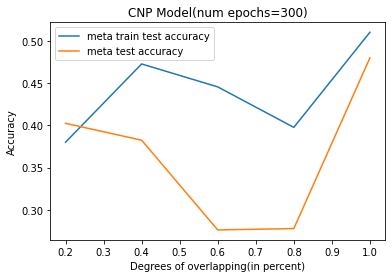

In [ ]:
# import numpy as np
# import matplotlib.pyplot as plt
# #Plot
# x=[0.2,0.4,0.6,0.8,1]
# y1=[0.38,0.4728,0.4456,0.3976,0.5104]
# y2=[0.4024,0.3824,0.276,0.2776,0.48]
# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="upper left")
# plt.xlabel("Degrees of overlapping(in percent)")
# plt.ylabel("Accuracy")
# plt.title("CNP Model(num epochs=300)")


Text(0.5, 1.0, 'MAN Model(num_epochs=100)')

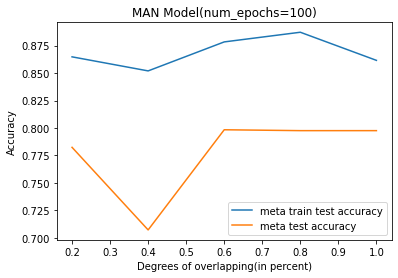

In [ ]:

# x=[0.2,0.4,0.6,0.8,1]
# y1=[0.8648, 0.852, 0.8784,0.8872,0.8616]
# y2=[0.7824,0.7072,0.7984,0.7976,0.7976]
# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="lower right")
# plt.xlabel("Degrees of overlapping(in percent)")
# plt.ylabel("Accuracy")
# plt.title("MAN Model(num_epochs=100)")

Text(0.5, 1.0, 'CNP Model')

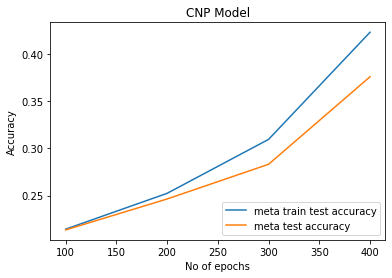

In [ ]:
# x=[100,200,300,400]
# y1=[0.21440,0.25240,0.30960,0.42320]
# y2=[0.21360,0.2464,0.28320,0.37600]

# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="lower right")
# plt.xlabel("No of epochs")
# plt.ylabel("Accuracy")
# plt.title("CNP Model")

Text(0.5, 1.0, 'MAN Model')

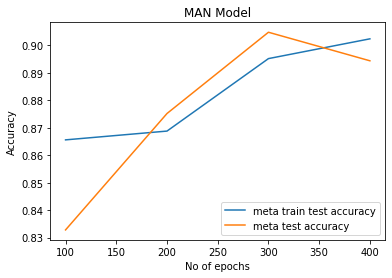

In [ ]:

# x=[100,200,300,400]
# y1=[0.86560,0.86880,0.89520,0.90240]
# y2=[0.83280,0.87520,0.90480,0.89440]


# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="lower right")
# plt.xlabel("No of epochs")
# plt.ylabel("Accuracy")
# plt.title("MAN Model")

Text(0.5, 1.0, 'MAML Model')

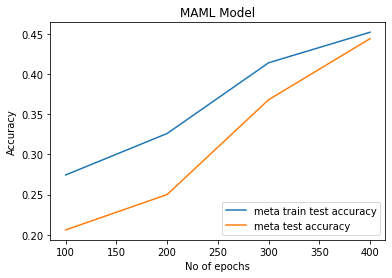

In [ ]:


# x=[100,200,300,400]
# y1=[0.27440,0.32600,0.41400,0.45200]
# y2=[0.20600,0.25000,0.36800,0.444000]

# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="lower right")
# plt.xlabel("No of epochs")
# plt.ylabel("Accuracy")
# plt.title("MAML Model")


Text(0.5, 1.0, 'Comparison of accuracy across Models')

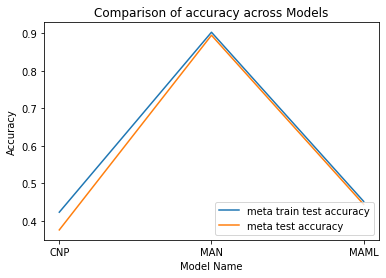

In [ ]:
# x=["CNP","MAN","MAML"]
# y1=[0.4232,0.9024,0.452]
# y2=[0.376,0.8944,0.444]

# plt.plot(x,y1)
# plt.plot(x,y2)
# plt.legend(['meta train test accuracy','meta test accuracy'] , loc ="lower right")
# plt.xlabel("Model Name")
# plt.ylabel("Accuracy")
# plt.title("Comparison of accuracy across Models")